In [1]:
import torch
from IPython.display import display
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from os import listdir
from os.path import isfile, join
from ipywebrtc import VideoStream # testing
import zipfile

In [ ]:
# Unzip dataset 
with zipfile.ZipFile('data/lego_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [2]:
annotations_path = 'data/annotations'
images_path = 'data/images'

In [3]:
random.seed(108)

In [4]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [5]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        """
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        """
        class_id = class_name_to_id_mapping[b["class"]]
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_path, info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [6]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
        
    plt.rcParams["figure.figsize"] = (20,10)
    plt.imshow(np.array(image))
    plt.show()

In [7]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            if f[-3:] == 'txt':
                shutil.move(f, destination_folder)
            if f[-3:] == "jpg":
                shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [8]:
def create_dataset_folder(name):
    os.makedirs('yolov5/' + name + '/images/train')
    os.makedirs('yolov5/' + name + '/images/val')
    os.makedirs('yolov5/' + name + '/images/test')

    os.makedirs('yolov5/' + name + '/labels/train')
    os.makedirs('yolov5/' + name + '/labels/val')
    os.makedirs('yolov5/' + name + '/labels/test')   

In [9]:
def clear_folder_data(destination_folder):
    for f in destination_folder:
        try:
            os.remove(f)
        except:
            assert False

In [10]:
class_name_to_id_mapping = {"brick_2x2": 0,
                           "brick_2x4": 1,
                           "brick_1x6": 2,
                           "plate_1x2": 3,
                           "plate_2x2": 4,
                           "plate_2x4": 5}

In [11]:
# Get the annotations
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "xml"]
annotations.sort()

In [12]:
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

100%|██████████████████████████████████████████████████████████████████| 3047/3047 [00:00<00:00, 11191.94it/s]


In [13]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

In [14]:
# Get any random annotation file 
annotation_file = random.choice(annotations)

In [15]:
# This doesn't work... 
# TODO fix
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

In [16]:
#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")

In [17]:
# TODO: maybe can remov this
assert os.path.exists(image_file)

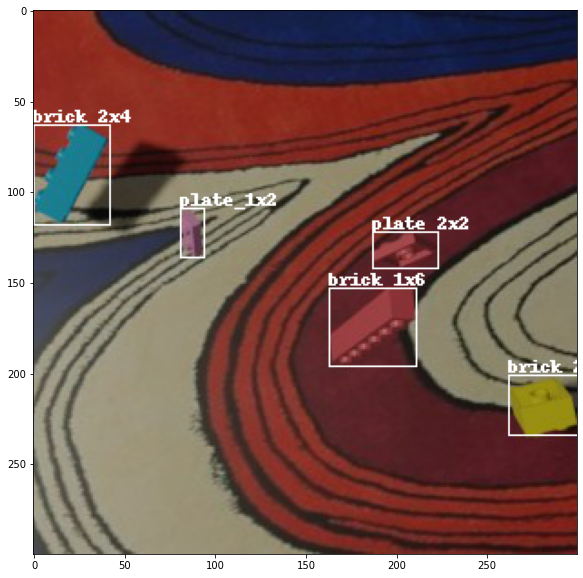

In [18]:
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [19]:
# Read images and annotations
images = [os.path.join(images_path, x) for x in os.listdir(images_path)]
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

In [20]:
images.sort()
annotations.sort()

In [21]:
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [22]:
dataset_name = 'lego_dataset'

In [23]:
# Clear folders of old images
if os.path.isdir('yolov5/' + dataset_name):
    shutil.rmtree('yolov5/' + dataset_name)

In [24]:
create_dataset_folder(dataset_name)

In [25]:
# Move the splits into their folders
move_files_to_folder(train_images, 'yolov5/lego_dataset/images/train')
move_files_to_folder(val_images, 'yolov5/lego_dataset/images/val/')
move_files_to_folder(test_images, 'yolov5/lego_dataset/images/test/')
move_files_to_folder(train_annotations, 'yolov5/lego_dataset/labels/train/')
move_files_to_folder(val_annotations, 'yolov5/lego_dataset/labels/val/')
move_files_to_folder(test_annotations, 'yolov5/lego_dataset/labels/test/')

In [4]:
cd yolov5

/home/mg/programming/Multi-object-detection-lego/yolov5


In [27]:
# define the project name
project_name = 'yolo_lego_det'

In [28]:
# Train the model
# Provided yaml file 
!python3 train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 16 --epochs 100 --data lego_data.yaml --weights yolov5s.pt --workers 24 --name {project_name}

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=lego_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_lego_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 b18cd70 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

      8/99      1.3G   0.03064   0.01725   0.03202        27       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.691      0.721      0.746       0.57

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      9/99      1.3G   0.02871   0.01672   0.03077        37       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.762       0.79      0.843      0.673

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     10/99      1.3G   0.02714   0.01648   0.02901        34       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.747      0.796       0.84      0.675

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     11/99      1.3G   0.02691   0.01


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     34/99      1.3G   0.01891   0.01324   0.01758        24       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.879      0.916      0.953      0.849

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     35/99      1.3G     0.019   0.01344   0.01755        32       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.913      0.898      0.957      0.853

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     36/99      1.3G   0.01887    0.0137   0.01756        20       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.887      0.909      0.955      0.858

     Epoch   gpu_mem       box      


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     85/99      1.3G   0.01291   0.01073  0.009687        28       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.963       0.91      0.973      0.913

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     86/99      1.3G   0.01264   0.01043  0.009367        27       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.947      0.922      0.974      0.918

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     87/99      1.3G   0.01274   0.01066  0.009483        16       320: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        305        970      0.953       0.93      0.976      0.918

     Epoch   gpu_mem       box      

runs/train/yolo_lego_det


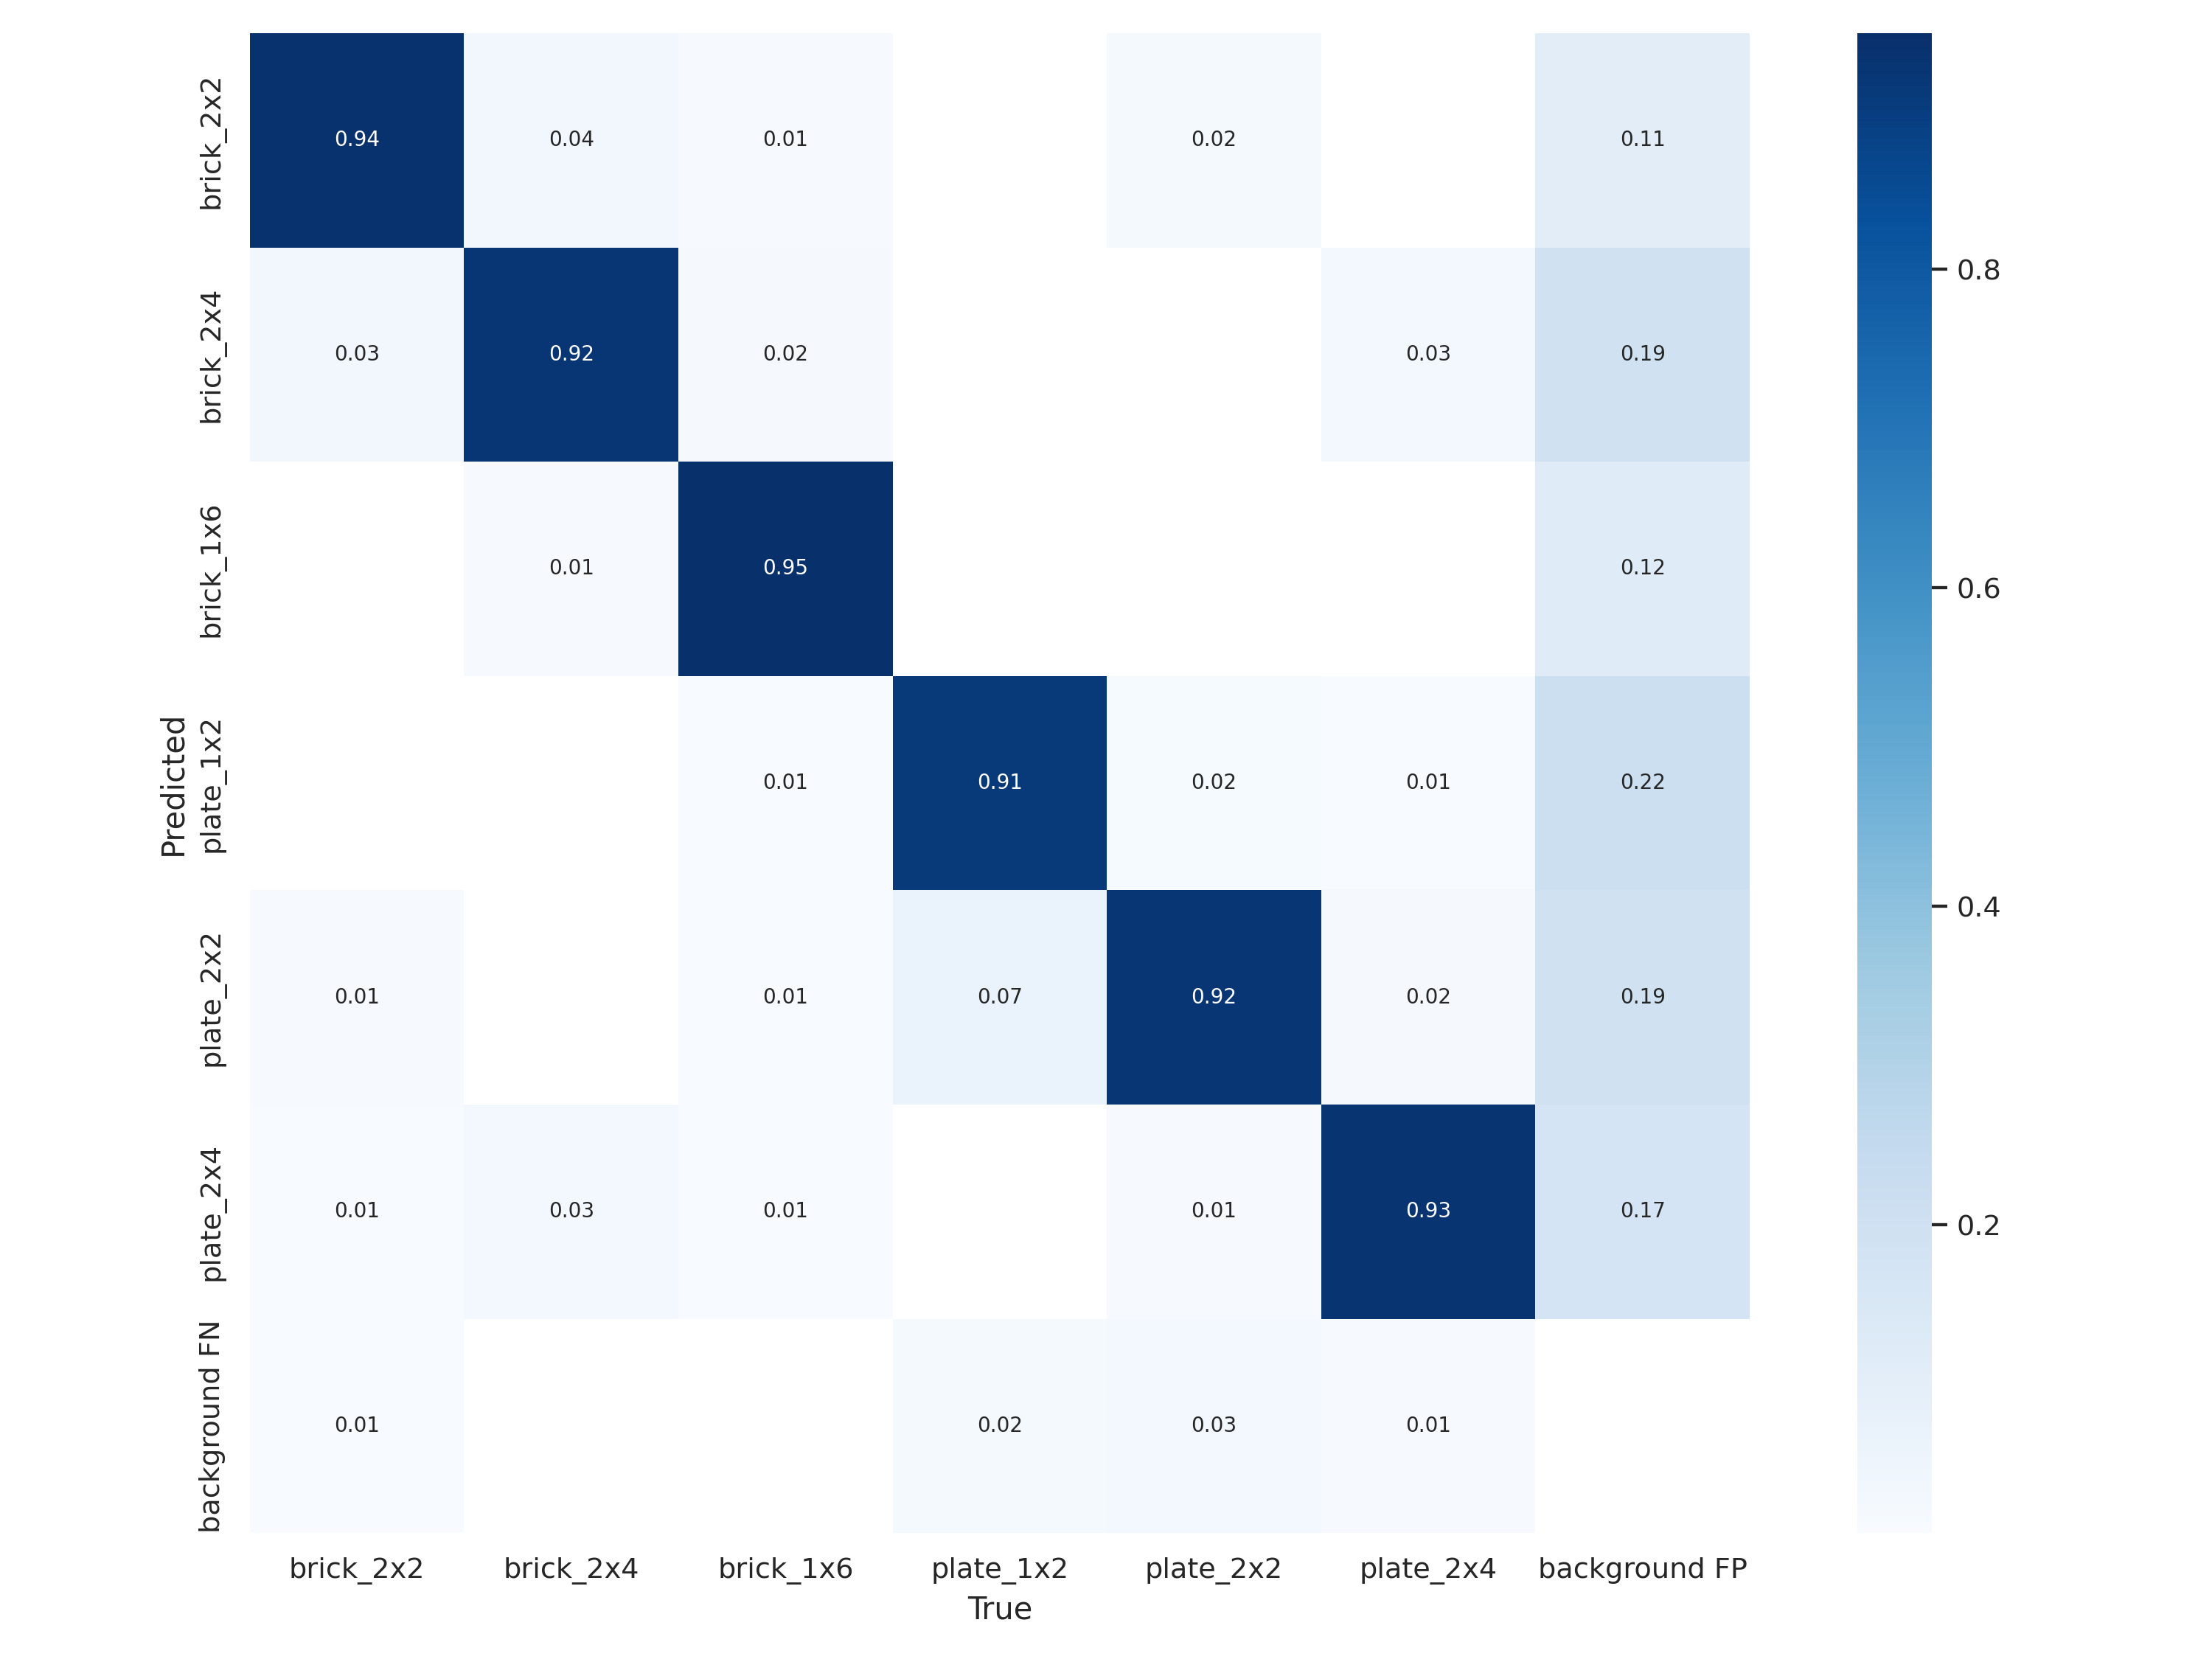

In [34]:
# Find the directory where train files are saved
# Show confusion matrix
directory_train = 'runs/train/'
latest_dir_train = max(pathlib.Path(directory_train).glob('*/'), key=os.path.getmtime)
print(latest_dir_train)
display(Image.open(str(latest_dir_train) + '/confusion_matrix.png'))



In [35]:
path_to_weigths = str(latest_dir_train) + '/weights/best.pt'
print(path_to_weigths)

runs/train/yolo_lego_det/weights/best.pt


In [36]:
# Run detection through test image dataset 
# Make sure to: cd yolov5

!python3 detect.py --img 300 --source lego_dataset/images/test/ --weights {path_to_weigths} --conf 0.25 --name {project_name}


detect: weights=['runs/train/yolo_lego_det/weights/best.pt'], source=lego_dataset/images/test/, imgsz=[300, 300], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lego_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Save dir:  runs/detect/yolo_lego_det2

YOLOv5 🚀 b18cd70 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

Fusing layers... 
/home/mg/programming/yolo_venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7026307 parameters, 0 gradients,

image 54/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00481.jpg: 320x320 2 brick_2x2s, 1 plate_1x2, 1 plate_2x2, Done. (0.004s)
image 55/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00490.jpg: 320x320 1 brick_1x6, 1 plate_2x2, Done. (0.004s)
image 56/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00495.jpg: 320x320 1 brick_2x2, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
image 57/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00516.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 plate_2x2, Done. (0.004s)
image 58/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00547.jpg: 320x320 1 brick_1x6, 2 plate_1x2s, 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
image 59/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/00558.jpg: 320x320 1 brick_2x2, 1 plate_1x2, 1 plate_2x2, 1 plate_2

image 107/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01038.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_2x2, Done. (0.004s)
image 108/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01039.jpg: 320x320 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, Done. (0.004s)
image 109/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01041.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
image 110/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01070.jpg: 320x320 1 brick_2x2, 1 plate_1x2, Done. (0.004s)
image 111/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01077.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 plate_1x2, 2 plate_2x2s, 1 plate_2x4, Done. (0.004s)
image 112/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/tes

image 157/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01532.jpg: 320x320 1 brick_2x4, 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
image 158/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01539.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 plate_1x2, 1 plate_2x2, Done. (0.004s)
image 159/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01540.jpg: 320x320 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
image 160/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01546.jpg: 320x320 1 brick_2x2, 1 plate_1x2, 1 plate_2x2, Done. (0.004s)
image 161/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01562.jpg: 320x320 1 brick_2x4, 2 plate_2x2s, Done. (0.004s)
image 162/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01564.jpg: 320x320 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, Done.

image 206/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01934.jpg: 320x320 1 brick_2x2, 1 brick_2x4, Done. (0.004s)
image 207/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01938.jpg: 320x320 2 brick_2x4s, 1 plate_1x2, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
image 208/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01951.jpg: 320x320 1 brick_2x2, 2 brick_1x6s, 2 plate_2x2s, Done. (0.004s)
image 209/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01961.jpg: 320x320 1 brick_2x4, 1 plate_1x2, Done. (0.004s)
image 210/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01967.jpg: 320x320 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
image 211/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/01973.jpg: 320x320 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done

image 258/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02436.jpg: 320x320 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
image 259/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02438.jpg: 320x320 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
image 260/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02459.jpg: 320x320 2 brick_2x2s, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
image 261/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02470.jpg: 320x320 1 brick_2x2, 2 brick_2x4s, 2 plate_2x2s, 1 plate_2x4, Done. (0.004s)
image 262/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02484.jpg: 320x320 1 brick_2x4, 1 brick_1x6, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
image 263/305 /home/mg/programming/Multi-object-detection-lego/yolov5/lego_dataset/images/test/02500.jpg: 320x320 1 b

In [37]:
# Get directory where results are saved

directory = 'runs/detect/'
latest_dir_results = max(pathlib.Path(directory).glob('*/'), key=os.path.getmtime)
print(latest_dir_results)

runs/detect/yolo_lego_det2


02920.jpg


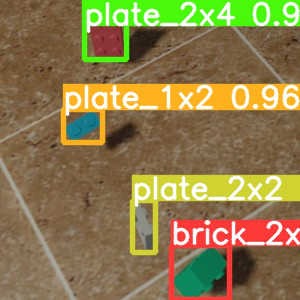

---------
00366.jpg


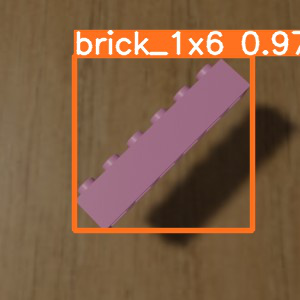

---------
00394.jpg


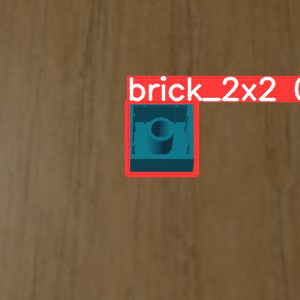

---------
00297.jpg


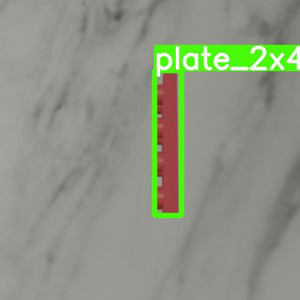

---------
01896.jpg


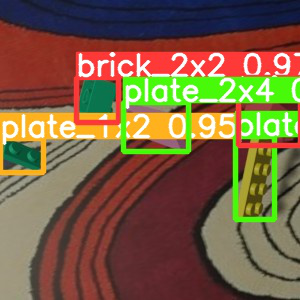

---------
01851.jpg


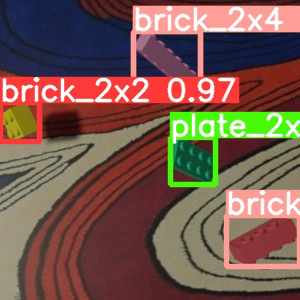

---------
00045.jpg


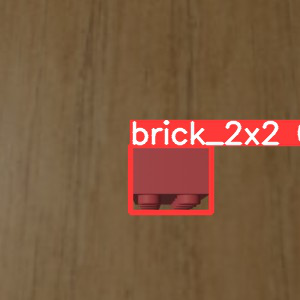

---------
01427.jpg


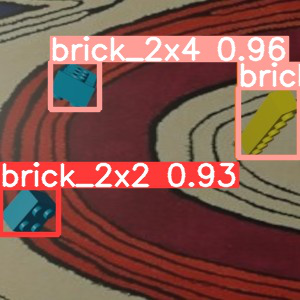

---------
00473.jpg


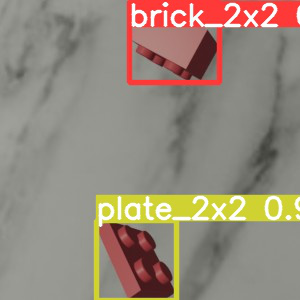

---------
00013.jpg


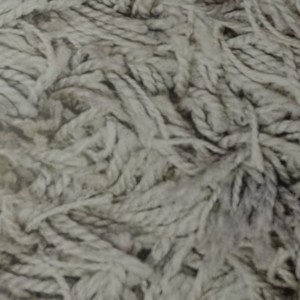

---------
02402.jpg


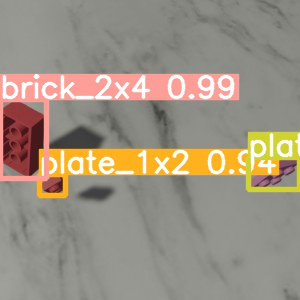

---------
01605.jpg


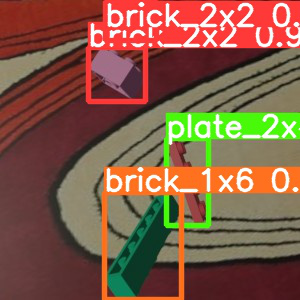

---------
01386.jpg


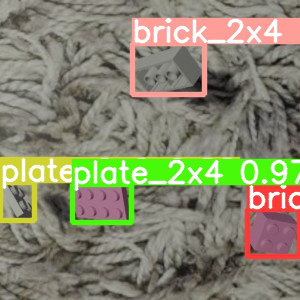

---------
00220.jpg


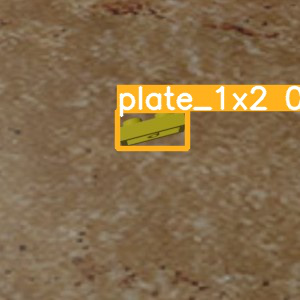

---------
02459.jpg


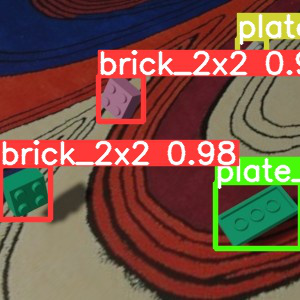

---------
02183.jpg


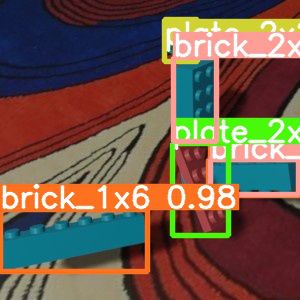

---------
00632.jpg


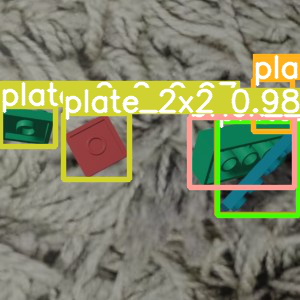

---------
00442.jpg


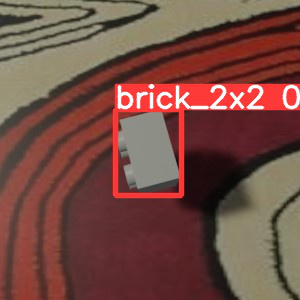

---------
01586.jpg


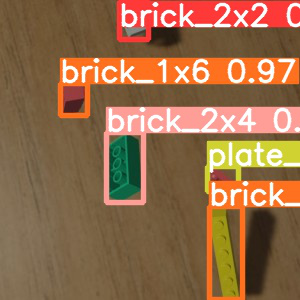

---------
00464.jpg


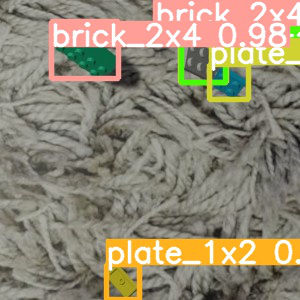

---------
02062.jpg


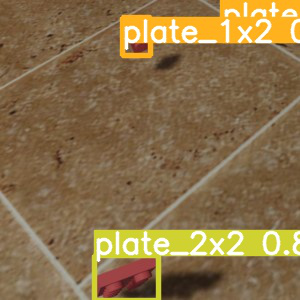

---------
01430.jpg


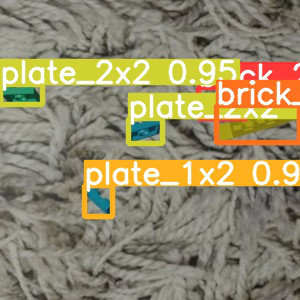

---------
02209.jpg


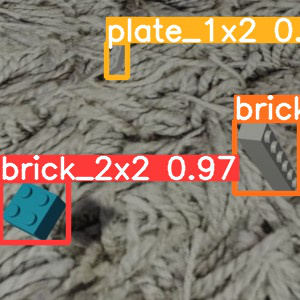

---------
01846.jpg


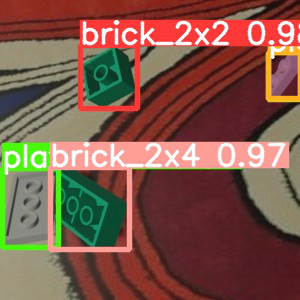

---------
02369.jpg


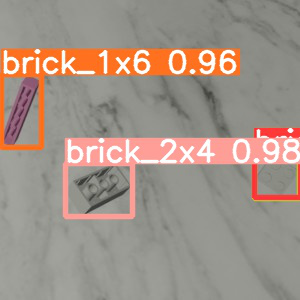

---------
00973.jpg


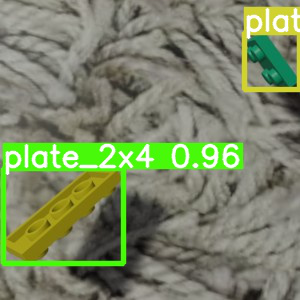

---------
01287.jpg


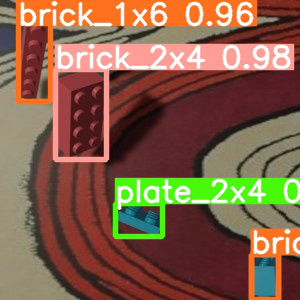

---------
00895.jpg


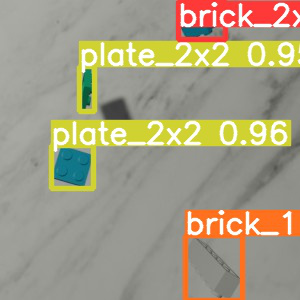

---------
02406.jpg


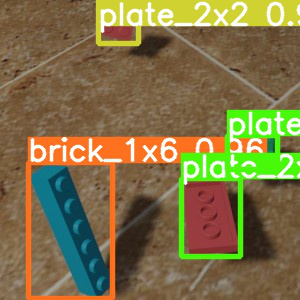

---------


In [38]:
# Show first 30 results of test images

images_list_results = [f for f in listdir(latest_dir_results) if isfile(join(latest_dir_results, f))]
count = 0

for imageName in images_list_results:
    count += 1
    if count >= 30:
        break
    else:
        print(imageName)
        display(Image.open(str(latest_dir_results) + '/' + imageName))
        print('---------')
    
    

detect: weights=['runs/train/yolo_lego_det/weights/best.pt'], source=../real_lego_images/03513.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lego_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Save dir:  runs/detect/yolo_lego_det3

YOLOv5 🚀 b18cd70 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

Fusing layers... 
/home/mg/programming/yolo_venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7026307 parameters, 0 gradie

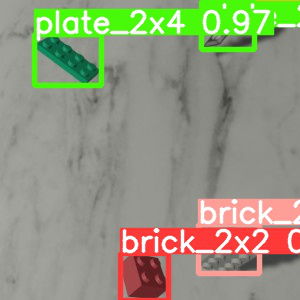

In [39]:
# Detect from a single image

!python3 detect.py --source ../real_lego_images/03513.jpg --weights {path_to_weigths} --conf 0.25 --name {project_name}

# Show results
latest_dir_results = max(pathlib.Path(directory).glob('*/'), key=os.path.getmtime)
print(latest_dir_results)
display(Image.open(str(latest_dir_results) + '/' + '03513.jpg'))

In [7]:
# Detect from webcam
# Video will be saved in yolov5/runs/detection
#!python3 detect.py --source 0 --weights {path_to_weigths} --conf 0.25 --name {project_name}
!python3 detect.py --source 0 --weights runs/train/yolo_lego_det/weights/best.pt --conf 0.25 --name yolo_lego_det

detect: weights=['runs/train/yolo_lego_det/weights/best.pt'], source=0, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lego_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Save dir:  runs/detect/yolo_lego_det4

YOLOv5 🚀 26af33b torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

Fusing layers... 
/home/mg/programming/yolo_venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Results sav

0: 480x640 2 brick_2x4s, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 1 brick_1x6, 1 plate_2x4, Done. (0.006s)
0: 480x640 2 brick_2x4s, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x

0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_2x4s, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
0: 480x640

0: 480x640 1 brick_2x2, 3 brick_2x4s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_2x4s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 1 plate_2x4, Done. (0.005s)
0: 480x640 2 brick_2x4s, 1 plate_2x4, Done. (0.004s)
0: 480x640 2 brick_2x4s, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 plate_2x4, Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 48

0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 2 plate_2x4

0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 4 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 4 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 4 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 4 plate_2x4s, Done. (0.006s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 4 plate_2x4s, D

0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 2 brick_1x6s, 4 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 2 brick_1x6s, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 2 brick_1x6s, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 2 brick_1x6s, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 2 brick_1x6s, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 4 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 4 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 

0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 3 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1

0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 br

0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 

0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_1x2s, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_1x2s, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_1x2s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_1x2s, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2

0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.006s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_1x2s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_1x2s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_1x2s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 3 plate_1x2s, 2 plate_

0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.006s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 

0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 2 brick_2x2s, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 2 brick_2x2s, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 2 brick_2x2s, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 2 brick_2x2s, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 2 brick_2x2s, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0

0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_2x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)


0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)


0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 

0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x2s, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 1 brick_1x6, 2 plate_2x2s, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0

0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 1 plate_2x4, Done. (0.004s)


0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_2x4, 2 brick_1

0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x4, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2, 3 plate_2x4s, Done. (0.005s)
0: 480x640 2 brick_2x2s, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 2 brick_2x2s, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.005s)
0: 480x640 2 brick_2x2s, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 2 brick_2x2s, 1 brick_2x4, 1 brick_1x6, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 brick_2x2, 1 brick_1x6, 1 plate_1x2

0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.006s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 1 plate_2x4, Done. (0.004s)
0: 480x640 1 plate_2x4, Done. (0.005s)
0: 480x640 1 plate_2x4, Done. (0.004s)
0: 480x640 1 plate_2x4, Done. (0.004s)
0: 480x640 1 plate_2x4, Done. (0.004s)
0: 480x640 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 1 brick_1x6, 1 plate_2x4, Done. (0.005s)
0: 480x640 1 brick_1x6, 1 plate_2x4, Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.004s)
0: 480x640 Done. (0.005s)
0: 480x640 1 plate_2x2, 2 plate_2x4s, Done. (0.004s)
0: 480x640 1 plate_2x2, 2 plate_2x4s,

In [51]:
# Detect from video 

!python3 detect.py --source /home/mg/Downloads/output2.mp4 --weights runs/train/yolo_lego_det3/weights/best.pt --conf 0.25 --name {project_name}


detect: weights=['runs/train/yolo_lego_det3/weights/best.pt'], source=/home/mg/Downloads/output2.mp4, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lego_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Save dir:  runs/detect/yolo_lego_det29

YOLOv5 🚀 06f9a3c torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

Fusing layers... 
/home/mg/programming/yolo_venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7026307 parameters, 0 gra

video 1/1 (61/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 4 brick_1x6s, 1 plate_1x2, 2 plate_2x4s, Done. (0.005s)
video 1/1 (62/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 4 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (63/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.006s)
video 1/1 (64/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 3 brick_1x6s, 1 plate_2x4, Done. (0.005s)
video 1/1 (65/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 3 plate_2x4s, Done. (0.005s)
video 1/1 (66/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 2 plate_2x4s, Done. (0.006s)
video 1/1 (67/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 2 brick_1x6s, 1 plate_2x2, 4 plate_2x4s, Done. (0.005s)
video 1/1 (68/213) /home/mg/Downloads/output2.mp4: 384x

video 1/1 (124/213) /home/mg/Downloads/output2.mp4: 384x640 4 brick_2x4s, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x2, 2 plate_2x4s, Done. (0.005s)
video 1/1 (125/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 3 brick_2x4s, 3 brick_1x6s, 1 plate_1x2, 2 plate_2x2s, 1 plate_2x4, Done. (0.005s)
video 1/1 (126/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 3 brick_2x4s, 3 brick_1x6s, 2 plate_2x2s, 2 plate_2x4s, Done. (0.005s)
video 1/1 (127/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 2 brick_2x4s, 2 brick_1x6s, 1 plate_1x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (128/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 3 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (129/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_1x2, 2 plate_2x2s, 1 plate_2x4, Done. (0.005s)
video 1/1 (130/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 3 brick_2x4s, 3 brick_1x6s, 1 plate_1x2, Done.

video 1/1 (184/213) /home/mg/Downloads/output2.mp4: 384x640 2 brick_2x2s, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.006s)
video 1/1 (185/213) /home/mg/Downloads/output2.mp4: 384x640 2 brick_2x2s, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (186/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (187/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.004s)
video 1/1 (188/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x4, Done. (0.005s)
video 1/1 (189/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (190/213) /home/mg/Downloads/output2.mp4: 384x640 1 brick_2x2, 1 brick_2x4, 2 brick_1x6s, 1 plate_2x2, 1 plate_2x4, Done. (0.005s)
video 1/1 (191/213) /home/mg/Downloads/output2.mp4

In [5]:
# Test detection on custom folder 

!python3 detect.py --img 300 --source test/ --weights runs/train/yolo_lego_det/weights/best.pt --conf 0.25 --name yolo_lego_det


detect: weights=['runs/train/yolo_lego_det/weights/best.pt'], source=test/, imgsz=[300, 300], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lego_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Save dir:  runs/detect/yolo_lego_det5

YOLOv5 🚀 a64c760 torch 1.10.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7979.1875MB)

Fusing layers... 
/home/mg/programming/yolo_venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
image 1